$\newcommand{\ht}{\hat \theta} $
$\newcommand{\vt}{\vec \theta} $
$\newcommand{\ve}{\vec \epsilon} $
$\newcommand{\vx}{\vec x} $
$\newcommand{\vy}{\vec y} $
$\newcommand{\hess}{H^T \Sigma^{-1} H}$
$\newcommand{\ce}{{\cal E}}$
$\newcommand{\cl}{{\cal L}}$
$\newcommand{\cn}{{\cal N}}$
$\newcommand{\LH}{{\cal L}(\vx|\vt)}$
$\newcommand{\PO}{{P}(\vt|\vx)}$
$\newcommand{\PR}{{P}(\vt)}$
$\newcommand{\EV}{{P}(\vx)}$
$\newcommand{\eqnp}[1]{\begin{pmatrix} #1 \end{pmatrix}}$
$\newcommand{\eqnb}[1]{\begin{bmatrix} #1 \end{bmatrix}}$

In [139]:
from __future__ import print_function


%matplotlib inline

import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("ticks")
plt.rcParams['figure.figsize'] = [16, 8]

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Ignore Python warnings

import warnings
from IPython.display import display

warnings.filterwarnings('ignore')


# KNN Methods for Classification, Regression, and Oversampling
**Sarah Allam s3747328**

This is a tutorial for the KNN applications on tasks of classification, regression, and SMOTE. For the classification and the oversampling tasks, we will illustrate the performance of KNN on the DREAM Challenge.
DREAM is a supervised classification problem consisting of 359 total input samples, with only 179 labeled samples, and 186 input features. Therefore, the training set is 179 samples and the test set is 180 samples. The problem is to correctly classify the remaining 180 samples as patients with Acute Myeloid Leukemia (AML) or healthy patients (a binary problem). In addition, the dataset is highly imbalanced, with a majority of the samples pertaining to the healthy class. There are only 20 AML samples in the 180 test set.
This is a difficult task and to balance the data of the two classes, we will use SMOTE.

<h1>Table of Contents<span class="tocSkip"></span></h1>

In [140]:
def plot_data_distribution(data, labels):
    '''
    Plots the imbalanced binary classes.
    :param data: inputs, x
    :param labels: categorical class labels for the inputs, y
    '''
    X_train = data[0:len(labels)]

    # plot data distribution
    healthy = X_train[labels == 1]
    aml = X_train[labels == 2]

    plt.bar(['Healthy', 'AML'], [healthy.shape[0], aml.shape[0]])
    plt.text(0, healthy.shape[0] + 1, str(healthy.shape[0]), ha='center')
    plt.text(1, aml.shape[0] + 1, str(aml.shape[0]), ha='center')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Data Distribution')
    plt.show()

A histogram is a good data vizualization method in order to check the distribution of the data between classes.
We can see that the data for the AML patients has very few samples compared to the data with the majority healthy patients.

'Number of features: '

186

'Number of samples: '

359

'Number of labels: '

179

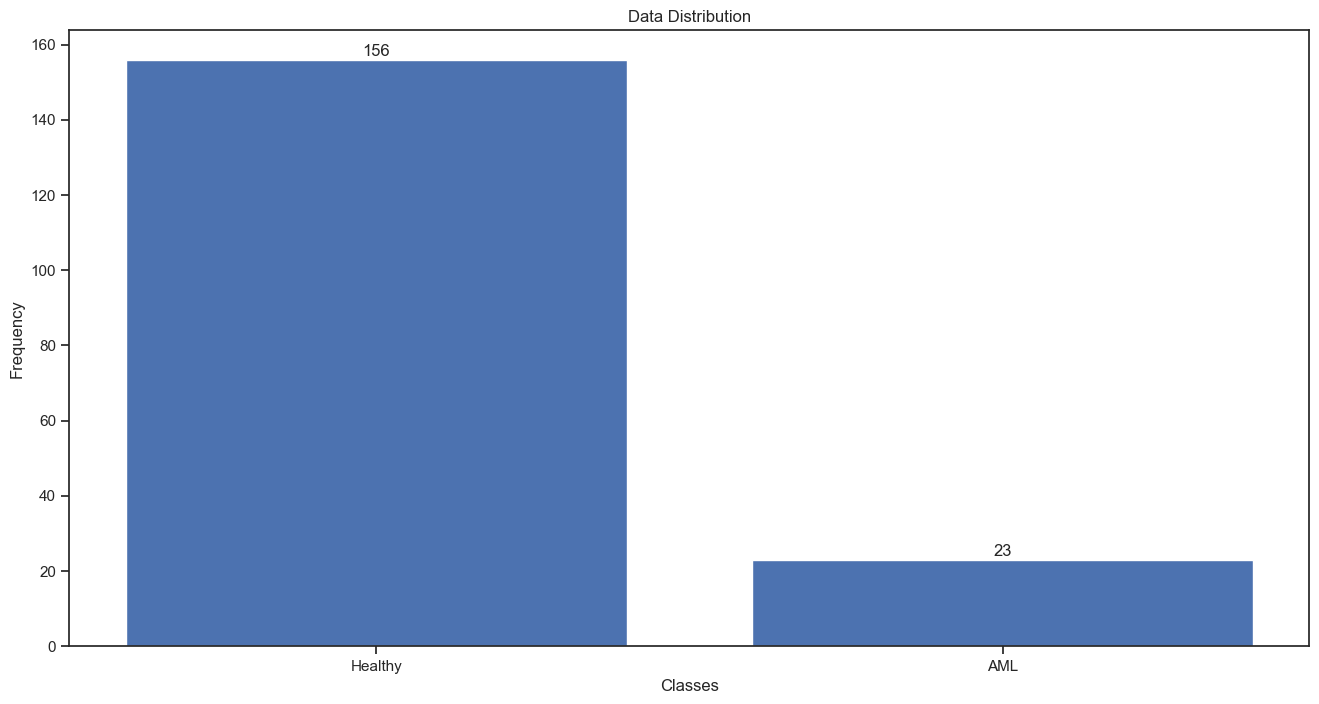

In [141]:
def load_data():
    # Load data
    data =np.genfromtxt("data.csv", delimiter=",")
    labels = np.genfromtxt("labels.csv", delimiter=",")
    # data = np.loadtxt('data.csv')
    # labels = np.loadtxt('labels.csv')

    # print number of features and the number of samples
    display("Number of features: ", data.shape[1])
    display("Number of samples: ", data.shape[0])
    display("Number of labels: ", labels.shape[0])
    return data, labels

data, labels = load_data()
plot_data_distribution(data, labels)

In [142]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, \
    recall_score, f1_score

def calculate_metric_clf(y_test, y_):
    '''
    alculates accuracy, precision, recall, f1-score
    :param y_test: true labels of the test set
    :param y_: predicted labels of the test set
    :return: accuracy, precision, recall, f1-score
    '''
    accuracy = accuracy_score(y_test, y_)
    precision = precision_score(y_test, y_)
    recall = recall_score(y_test, y_)
    f1 = f1_score(y_test, y_, average='weighted')

    return accuracy, precision, recall, f1

Accuracy is not a good metric score for imbalanced datasets. Classification models tend to overfit on the majority class.
This also applies to KNN, since the boundary between the two clusters will be defined by mostly healthy samples. Therefore,
the KNN model will tend to be biased towards the majority class. For example, in case the model is completely biased towards the majority class and
classifies any incoming inputs as the majority class, the accuracy will still be high:

\begin{align}
accuracy = 156 * 100 / 179 =87,15\%
\end{align}

Even when all the minority class samples are misclassified, the accuracy is still 87,15\%.
Instead, we should use precision, recall, and f1-score, which together show information about the rate of true positives, true ngatives, false positives, and false negatives :

\begin{align}
precision = true\_positives / (true\_positives + false\_positives) \\
precision = 156 / (156 + 23)=87,15\%
\end{align}



\begin{align}
recall = true\_positives / (true\_positives + true\_negatives) \\
recall = 156 / (156 + 0)=100\%
\end{align}

\begin{align}
recall = 2 * precision * recall / (precision + recall) \\
recall = 93,133\%
\end{align}

The F1-score is a combination between precision and recall. Accuracy does not allow to separate the weight given to the false negatives (AML patients classified as healthy) from false positives (healthy patients classified as AML patients).
In the medical domain, it is more grave to miss an AML patient as being healthy, and therefore endangering their life, than treating a healthy patient as a possibly AML patient, which would just result in more tests.
Therefore, the metrics used for imbalanced datasets where class predictions are not equally important must be chosen carefully.

Next, we will look at a KNN classification on the popular IRIS dataset, where we will only take into consideration 2 features from the dataset in order to plot the KNN boundaries on the predictions.

You can interact with the graph by changing the hyperparameters of the KNN model:
1. Number of neighbours: this is usually written as 'k' (K-Nearest Neighbours) and decides how many samples will be used to calculate the distance between the input to be classified and the samples in the vicinity. A number that is too small will not generalize well, while a number that is too high will lead to the majority class completely overtaking the minority samples.
2. Weight determining neighbours: ‘uniform’ weights all the neighbouring samples equally, while 'distance' weights samples by the inverse of their distance

In [143]:
'''
Load the IRIS dataset and split the data into a training set and a test set
'''

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris(as_frame=True)
X = iris.data[["sepal length (cm)", "sepal width (cm)"]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.inspection import DecisionBoundaryDisplay


# Function to generate and plot points
def generate_knn_iris(n_neighbors, knn_weights):
    '''
    KNN classifier applied on the IRIS dataset. Plots the 2 features of the data and the KNN boundaries
    :param n_neighbors: k
    :param knn_weights: uniform or distance
    :return: plot
    '''
    np.random.seed(42)  # Set seed for reproducibility

    clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=n_neighbors, weights=knn_weights))]
    )
    _, axs = plt.subplots(ncols=1, figsize=(12, 5))

    clf.set_params(knn__weights=knn_weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading="auto",
        alpha=0.5,
        ax=axs,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        iris.target_names,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={knn_weights!r})"
    )
    plt.show()

# Interactive sliders for the number and variance of points
interact(
    generate_knn_iris,
    n_neighbors=widgets.IntSlider(min=1, max=30, step=1, value=20, description='Number of neighbours:'),
    knn_weights = widgets.Dropdown(
    options=[("uniform", "uniform"), ("distance", "distance")],
    value="uniform",
    description='Weight determining neighbours:',
    )
)

interactive(children=(IntSlider(value=20, description='Number of neighbours:', max=30, min=1), Dropdown(descri…

<function __main__.generate_knn_iris(n_neighbors, knn_weights)>

We return to our DREAM challenge, on the AML dataset. Since there are more than 2 features, we cannot plot all of the feature space against the boundaries, but we can plot the binary class probabilities against two selected features and observe the false negatives/positives rates and the importance of the features for the classification.
After we fit the KNN model on the training set, we plot the probability of each class for the test set samples. The classes are one-hot encoded: it transforms categorical data into integers. The first class, class '1', is the 'healthy' class. The second class, class '2', is the 'AML' minority class.
You can hover over each data point in order to observe the probability of either class and the true label.
There are very few samples in the minority class compared to the majority one, and their class probabilities are spread out. In comparison, the majority class samples tend to have a lower variance within the feature space.
Change the two features and see how the probabilities for the classification change alongside the spread of the samples in the feature space.

In [144]:

import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

from sklearn.model_selection import train_test_split


X = data[:179]
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.inspection import DecisionBoundaryDisplay


# Function to generate and plot points
def generate_knn_clf(n_neighbors, knn_weights,feature_1, feature_2):
    '''
    KNN Classification for the AML dataset. Plots 2 features and the class probabilities.
    :param n_neighbors: k
    :param knn_weights: uniform or distance
    :param feature_1: index of the x-axis feature
    :param feature_2: index of the y-axis feature
    :return:
    '''
    np.random.seed(42)  # Set seed for reproducibility

    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=knn_weights)
    clf = clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:, 1]
    # this one gives a categorical prediction instead of a probability
    y_pred = clf.predict(X_test)

    fig = px.scatter(
        X_test, x=feature_1, y=feature_2,
        color=y_score, color_continuous_scale='RdBu',
        symbol=np.squeeze(y_test),
        symbol_map={'1': 'square-dot', '2': 'circle-dot'},
        labels={'symbol': 'label', 'color': 'score of <br>first class'}
    )
    fig.update_traces(marker_size=12, marker_line_width=1.5)
    fig.update_layout(legend_orientation='h')
    fig.show()

# Interactive sliders for the number and variance of points
interact(
    generate_knn_clf,
    n_neighbors=widgets.IntSlider(min=1, max=50, step=1, value=11, description='Number of neighbours:'),
    knn_weights = widgets.Dropdown(
    options=[("uniform", "uniform"), ("distance", "distance")],
    value="uniform",
    description='Weight determining neighbours:',
    ),
    feature_1=widgets.IntSlider(min=0, max=185, step=1, value=0, description='Index of Feature 1:'),
    feature_2=widgets.IntSlider(min=0, max=185, step=1, value=1, description='Index of Feature 2:'),

)

interactive(children=(IntSlider(value=11, description='Number of neighbours:', max=50, min=1), Dropdown(descri…

<function __main__.generate_knn_clf(n_neighbors, knn_weights, feature_1, feature_2)>

We can apply Principal Component Analysis (PCA) in order to select the best 2 features for plotting the class probabilities.
However, for non-illustrative purposes, we would apply PCA and then keep enough features in order to explain at least 95% of the variance in the data.
When applying PCA, it is important to avoid data leakage. Data leakage happens when information from the training test skews the test set, and therefore the test set becomes biased and is not representative of a generalized performance of the model anymore.
Data leakage happens when we apply a dimensionality reduction method like PCA on the whole dataset, before splitting into training and test sets.
PCA should be applied separately on the training set and on the test set. If the training set is representative of the test set, the same features should be selected as the principal components for both sets, but that might not always be the case!
Below we plot the first and second best features as extracted by PCA and plo the boundaries of the two classes.

In [145]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

def pca(X_train, X_test, n_comps=2):
    '''
    Standardize data (subtract mean) and apply PCA on the test and training sets separately.
    :param X_train: training samples
    :param X_test: test samples
    :param n_comps: 2, for plotting
    :return: transformed train and test samples with only 2 best features
    '''
    # PCA (on all components)
    # standardize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    pca = PCA(n_components=n_comps)
    X_train = pd.DataFrame(pca.fit_transform(X_train))
    X_test = pd.DataFrame(pca.transform(X_test))
    explained_variance = np.round(pca.explained_variance_ratio_, decimals=3) * 100
    display("Explained Variance by the first 2 features: ", explained_variance[0] + explained_variance[1])
    display("Explained Variance: ", pca.explained_variance_ratio_)

    return X_train, X_test

def generate_knn_clf_feature_reduction(n_neighbors, knn_weights):
    '''
    KNN classification on AML with PCA
    :param n_neighbors: k
    :param knn_weights: uniform or distance
    :return: plots
    '''
    np.random.seed(42)  # Set seed for reproducibility

    # dimensionality reduction with PCA
    X_train_pca, X_test_pca = pca(X_train, X_test)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=knn_weights)
    _, axs = plt.subplots(ncols=1, figsize=(12, 5))
    display("Training set after PCA" , X_train_pca)
    clf.fit(X_train_pca, y_train)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test_pca,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="best feature pca",
        ylabel="second best feature pca",
        shading="auto",
        alpha=0.5,
        ax=axs,
    )
    scatter = disp.ax_.scatter(X_test_pca.iloc[:, 0], X_test_pca.iloc[:, 1], c=y_test, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        np.unique(y_test),
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"2-Class classification\n(k={clf.n_neighbors}, weights={knn_weights!r})"
    )
    plt.show()

interact(
    generate_knn_clf_feature_reduction,
    n_neighbors=widgets.IntSlider(min=1, max=50, step=1, value=11, description='Number of neighbours:'),
    knn_weights = widgets.Dropdown(
    options=[("uniform", "uniform"), ("distance", "distance")],
    value="uniform",
    description='Weight determining neighbours:',
    )
    # num_blue=widgets.IntSlider(min=1, max=200, step=1, value=100, description='Num Blue Points:'),
    # variance_red=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5, description='Var Red Points:'),
    # variance_blue=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=3.0, description='Var Blue Points:')
)

interactive(children=(IntSlider(value=11, description='Number of neighbours:', max=50, min=1), Dropdown(descri…

<function __main__.generate_knn_clf_feature_reduction(n_neighbors, knn_weights)>

In [146]:
#SMOTE
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler


def construct_oversampling(sampling_method, smote_sampling_strategy, X_train_pca, y_train):
    if sampling_method == 'SMOTE':
        sampler = SMOTE(sampling_strategy=smote_sampling_strategy)
        X_samples, y_samples = sampler.fit_resample(X_train_pca, y_train)
        return X_samples, y_samples
    if sampling_method == 'BorderlineSMOTE':
        sampler = BorderlineSMOTE( sampling_strategy=smote_sampling_strategy)
        X_samples, y_samples = sampler.fit_resample(X_train_pca, y_train)
        return X_samples, y_samples
    if sampling_method == 'ADASYN':
        sampler = ADASYN( sampling_strategy=smote_sampling_strategy)
        X_samples, y_samples = sampler.fit_resample(X_train_pca, y_train)
        return X_samples, y_samples
    if sampling_method == 'None':
        return X_train_pca, y_train


def construct_undersampling(sampling_method, smote_sampling_strategy, X_train_pca, y_train):
    if sampling_method == 'RandomUnderSampler':
        sampler = RandomUnderSampler( sampling_strategy=smote_sampling_strategy)
        X_samples, y_samples = sampler.fit_resample(X_train_pca, y_train)
        return X_samples, y_samples
    if sampling_method == 'None':
        return X_train_pca, y_train

def generate_knn_clf_smote(n_neighbors, knn_weights, oversampling_method, undersampling_method, smote_oversampling_strategy, smote_undersampling_strategy):
    np.random.seed(42)  # Set seed for reproducibility

    # dimensionality reduction with PCA
    X_train_pca, X_test_pca = pca(X_train, X_test)
    X_smote, y_smote = construct_undersampling(undersampling_method, smote_undersampling_strategy, X_train_pca, y_train)
    X_smote, y_smote = construct_oversampling(oversampling_method, smote_oversampling_strategy, X_smote, y_smote)

    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=knn_weights)
    _, axs = plt.subplots(ncols=1, figsize=(12, 5))
    clf.fit(X_smote, y_smote)

    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_smote,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="best feature pca",
        ylabel="second best feature pca",
        shading="auto",
        alpha=0.5,
        ax=axs,
    )
    scatter = disp.ax_.scatter(X_smote.iloc[:, 0], X_smote.iloc[:, 1], c=y_smote, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        np.unique(y_smote),
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"2-Class classification\n(k={clf.n_neighbors}, weights={knn_weights!r})"
    )
    plt.show()

    y_score = clf.predict_proba(X_smote)[:, 1]
    fig = px.scatter(
        X_smote, x=0, y=1,
        color=y_score, color_continuous_scale='RdBu',
        symbol=np.squeeze(y_smote),
        symbol_map={'0': 'square-dot', '1': 'circle-dot'},
        labels={'symbol': 'label', 'color': 'score of <br>first class'}
    )
    fig.update_traces(marker_size=12, marker_line_width=1.5)
    fig.update_layout(legend_orientation='h')
    fig.show()

    y_ = clf.predict(X_test_pca)
    accuracy, precision, recall, f1 = calculate_metric_clf(y_test, y_)
    display("Accuracy: ", accuracy)
    display("precision: ", precision)
    display("recall: ", recall)
    display("f1 score: ", f1)


interact(
    generate_knn_clf_smote,
    smote_oversampling_strategy = widgets.Dropdown(
    options=[("resample only the minority class", "minority"), ("resample all classes but the minority class", "not minority"),
             ("resample all classes but the majority class", "not majority"), ("resample all classes", "all")],
    value="minority",
    description='SMOTE Sampling Strategy:',
    ),
    smote_undersampling_strategy = widgets.Dropdown(
    options=[(" resample only the majority class", "majority"), ("resample all classes but the minority class", "not minority"),
             ("resample all classes but the majority class", "not majority"), ("resample all classes", "all")],
    value="majority",
    description='SMOTE Sampling Strategy:',
    ),
    oversampling_method =widgets.Dropdown(
    options=[("None", "None"), ("SMOTE", "SMOTE"), ("BorderlineSMOTE", "BorderlineSMOTE")],
    value="SMOTE",
    description='Oversampling Method:',
    ),
    undersampling_method =widgets.Dropdown(
    options=[("None", "None"), ("RandomUnderSampler", "RandomUnderSampler")],
    value="RandomUnderSampler",
    description='Undersampling Method:',
    ),
    n_neighbors=widgets.IntSlider(min=1, max=50, step=1, value=11, description='Number of neighbours:'),
    knn_weights = widgets.Dropdown(
    options=[("uniform", "uniform"), ("distance", "distance")],
    value="uniform",
    description='Weight determining neighbours:',
    )
    # num_blue=widgets.IntSlider(min=1, max=200, step=1, value=100, description='Num Blue Points:'),
    # variance_red=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5, description='Var Red Points:'),
    # variance_blue=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=3.0, description='Var Blue Points:')
)




interactive(children=(IntSlider(value=11, description='Number of neighbours:', max=50, min=1), Dropdown(descri…

<function __main__.generate_knn_clf_smote(n_neighbors, knn_weights, oversampling_method, undersampling_method, smote_oversampling_strategy, smote_undersampling_strategy)>

In [147]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
# Function to generate and plot points
def generate_knn_regressor(n_data_points, noise, n_neighbors, knn_weights):
    np.random.seed(42)
    X = np.sort(np.random.rand(n_data_points, 1), axis=0)
    T = np.linspace(0, 1, 500)[:, np.newaxis]
    y_true = np.sin(X).ravel() # select everything but the last 100 points
    y_test = np.sin(T).ravel() # select the last 100 points for test set
    # Add noise to targets
    # display(noise)
    # random_indices = np.random.choice(len(y), size=noise, replace=False)
    noise = np.random.normal(loc=0, scale=noise, size=len(y_true))

    # Add noise to the original array
    y = y_true + noise

    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=knn_weights)
    y_ = knn.fit(X, y).predict(T)

    error = np.sqrt(mean_squared_error(y_test, y_))
    display("Error is:  ", error)

    plt.subplot(1, 1, 1)
    plt.scatter(X, y, color="darkorange", label="noisy data")
    plt.plot(T, y_, color="navy", label="prediction")
    plt.plot(X, y_true, color="black", label="true function")
    plt.axis("tight")
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, knn_weights))

    plt.tight_layout()
    plt.show()

# Interactive sliders for the number and variance of points
interact(
    generate_knn_regressor,
    n_data_points=widgets.IntSlider(min=10, max=200, step=1, value=40, description='Number of data Points:'),
    noise=widgets.FloatSlider(min=0, max=2, step=0.1, value=0.1, description='Noise added to data:'),
    n_neighbors=widgets.IntSlider(min=1, max=50, step=1, value=11, description='Number of neighbours:'),
    knn_weights = widgets.Dropdown(
    options=[("uniform", "uniform"), ("distance", "distance")],
    value="uniform",
    description='Weight determining neighbours:',
    )
    # variance_blue=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=3.0, description='Var Blue Points:')
)


interactive(children=(IntSlider(value=40, description='Number of data Points:', max=200, min=10), FloatSlider(…

<function __main__.generate_knn_regressor(n_data_points, noise, n_neighbors, knn_weights)>